In [1]:
GPU = True
# !pip install shap
# from google.colab import output
# output.enable_custom_widget_manager()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.9 MB/s eta 0:00:00


In [2]:
import shap
import tqdm
import numpy as np
import torch.nn.functional as F

display_images = shap.datasets.imagenet50()[0].astype('uint8') # shape = (50, 224, 224, 3)

In [3]:
import torch
from torchvision import models

model = models.resnet18(pretrained=True)
model = model.eval() # turns off training mode for batch

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


In [4]:
import torchvision.transforms as transforms

# Image pre-processing, expects single image of size (224, 224, 3)
model_transforms = transforms.Compose([
transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [5]:
device = 'cuda' if GPU else 'cpu'
model = model.to(device)

## Occlusion

(a)

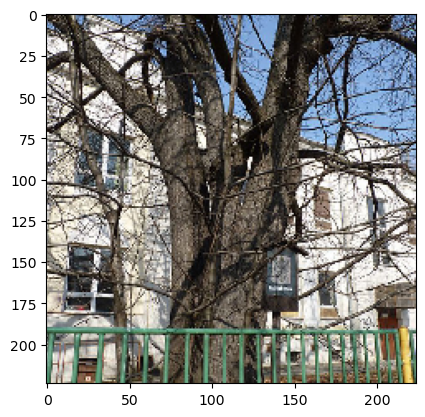

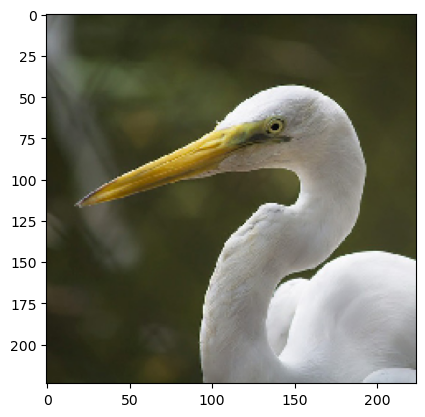

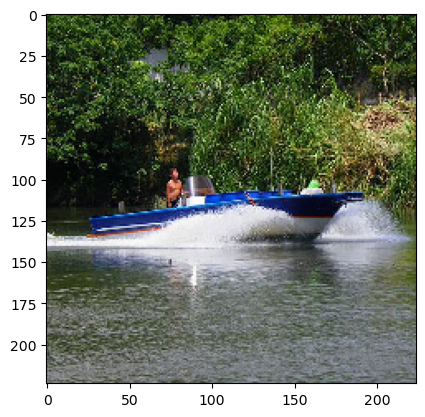

In [ ]:
import matplotlib.pyplot as plt

for i in range(3):
    # Generate plot
    plt.figure()
    plt.imshow(display_images[i])
    # plt.savefig(f"q2_a_{i}.png")
    plt.show()

(b)

In [6]:
# Apply pre-processing and make predictions
images = torch.stack([model_transforms(img) for img in display_images[:3]])
if GPU:
  images = images.to('cuda')
pred = model(images).softmax(dim=1)
pred_class_idx = torch.argmax(pred, dim=1)
pred_class_idx

tensor([829, 132, 814], device='cuda:0')

829: streetcar, tram, tramcar, trolley, trolley car

132: American egret, great white heron, Egretta albus

814: speedboat

(c) Feature importance value

There are many segementation algorithms for superpixels and here I just used 8*8 square-sized superpixels.
To improve the visualization, the `vmin` is set as the minimal value in the map and `vmax` is the maximal absolute value.

In [ ]:
#### TODO Update into batch-friendly function

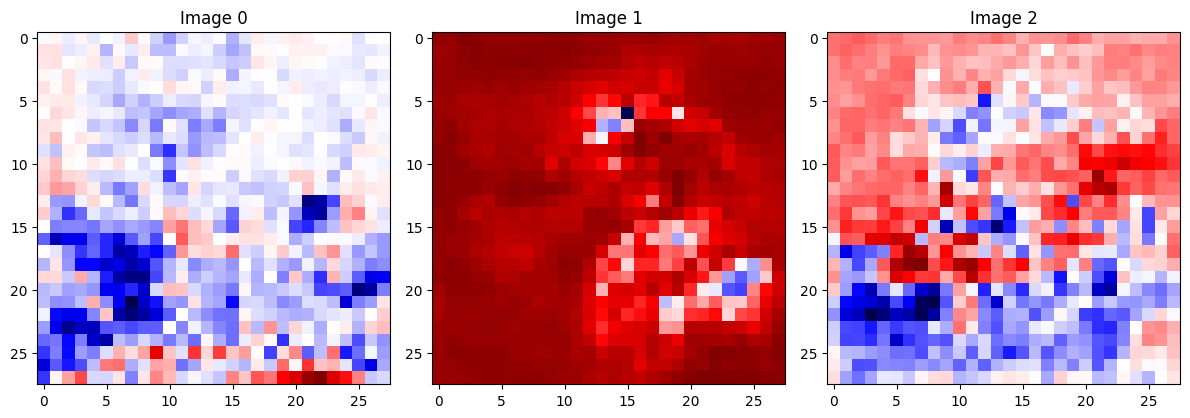

In [15]:
import tqdm
import matplotlib.pyplot as plt

def occlusion(imgs, model, target_labels, baseline, superpixel_size=8):
    ''' Args:
    imgs: torch.Tensor of pre-processed images, size = (batch, 3, 224, 224) model: PyTorch classifier
    target_labels: torch.Tensor of classes for each image, size = (batch,) baseline: baseline value for occluded features
    superpixel_size: width/height of superpixels
    Returns:
    importance: occlusion scores, size = (batch, 224, 224)
    '''

    # images = F.pad(imgs, (pad_W, pad_W, pad_H, pad_H), value=0)
    B, _, H, W = imgs.shape

    # Prepare sampling grids
    anchors = []
    grid_h = 0
    while grid_h <= H - superpixel_size:
        grid_w = 0
        while grid_w <= W - superpixel_size:
            anchors.append((grid_h, grid_w))
            grid_w += superpixel_size
        grid_h += superpixel_size

    # Compute per-pixel logits
    scoremaps = []
    # baseline_logits = model(baseline.unsqueeze(0)).softmax(dim=1).detach()[..., target_labels]

    for i in tqdm.tqdm(range(0, len(anchors)), leave=False):
        batch_images = []
        grid_h, grid_w = anchors[i]
        # for grid_h, grid_w in anchors[i : i + 1]:
        imgs_ = imgs.clone()
        imgs_[..., grid_h : grid_h + superpixel_size, grid_w : grid_w + superpixel_size] = baseline[..., grid_h : grid_h + superpixel_size, grid_w : grid_w + superpixel_size]
        batch_images = imgs_ # batch_images = torch.cat(batch_images, dim=0)
        scores = model(batch_images).softmax(dim=1).detach()
        # scores.shape (batchsize, num_classes 1000)
        # scores = scores.gather(1, target_labels)
        logits = scores[..., target_labels]
        # scoremaps += list(torch.split(logits - baseline_logits, B))
        scoremaps += list(torch.split(logits, B))

    importancemap = torch.cat(scoremaps, dim=0)
    importancemap = importancemap.view(B, imgs.shape[2]//superpixel_size, imgs.shape[3]//superpixel_size)
    #importance = F.interpolate(importancemap, size=(B, H, W), mode='nearest')
    #importance -= baseline

    return importancemap


# Generate black image, then apply pre-processing
baseline = model_transforms(np.zeros((224, 224, 3), np.uint8)).to(device)

occlusion_results = []
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    # Apply pre-processing and make predictions
    image = torch.stack([model_transforms(display_images[i])]).to(device)
    single_importance = occlusion(image, model, pred_class_idx[i], baseline)

    single_importance = single_importance.squeeze().cpu()#.numpy()
    occlusion_results.append(single_importance)

    # Generate plot
    # plt.figure()
    m = single_importance.abs().max()
    min = single_importance.min()
    axes[i].imshow(single_importance, vmin=min, vmax=m, cmap='seismic') # specify min/max value plt.show()
    axes[i].set_title(f'Image {i}')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()
# plt.savefig(f"q2_c.png")


(d) For the first of the three images, compare the results when using superpixels of size 4 × 4, 8 × 8 and 16 × 16. Plot the results side-by-side.

In [ ]:

occlusion_dicts = {4: [], 8: occlusion_results, 16: []}

for i in range(3):
    # Apply pre-processing and make predictions
    # image = torch.stack([model_transforms(img) for img in display_images[i]])
    image = torch.stack([model_transforms(display_images[i])]).to(device)
    for p in [4, 16]:
        single_importance = occlusion(image, model, pred_class_idx[i], baseline, superpixel_size=p)
        single_importance = single_importance.squeeze().cpu()
        occlusion_dicts[p].append(single_importance)


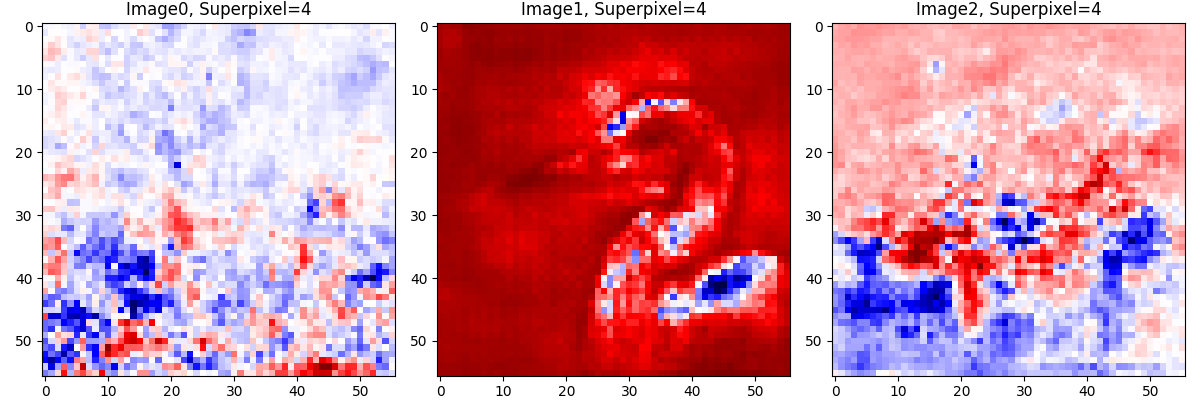

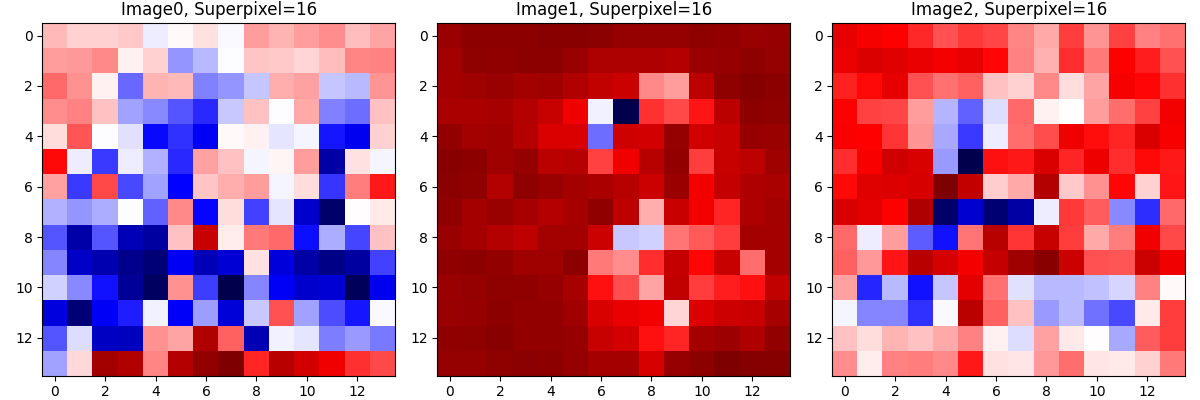

In [ ]:
import matplotlib.pyplot as plt

# Generate plot
# plt.figure()
# m = single_importance.abs().max()
# plt.imshow(single_importance, vmin=-m, vmax=m, cmap='seismic') # specify min/max value plt.show()

# Create a figure with three subplots
for p in [4,16]:
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  for i in range(3):
    # Plot the first image
    res = occlusion_dicts[p][i]
    m = res.abs().max()
    min = res.min()
    axes[i].imshow(res, vmin=min, vmax=m, cmap='seismic')
    axes[i].set_title(f'Image{i}, Superpixel={p}')

  # Adjust the spacing between subplots
  plt.tight_layout()

  # Display the figure
  plt.show()
  # plt.savefig(f"q2_d_{p}.png")


(e) As an alternative to replacing with zeros, we can use a blurred version of the image as a baseline. For the first of the three images, compare the occlusion results when using several blurring strengths, using 8 × 8 superpixels. Plot the results together, including the different blurred versions of the image. Hint: several Python packages offer functions to blur images, see here for example.

In [14]:
# !pip install scikit-image
# !pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.7 MB/s eta 0:00:00


In [16]:
import imageio.v3 as iio
import ipympl
import matplotlib.pyplot as plt
import skimage as ski

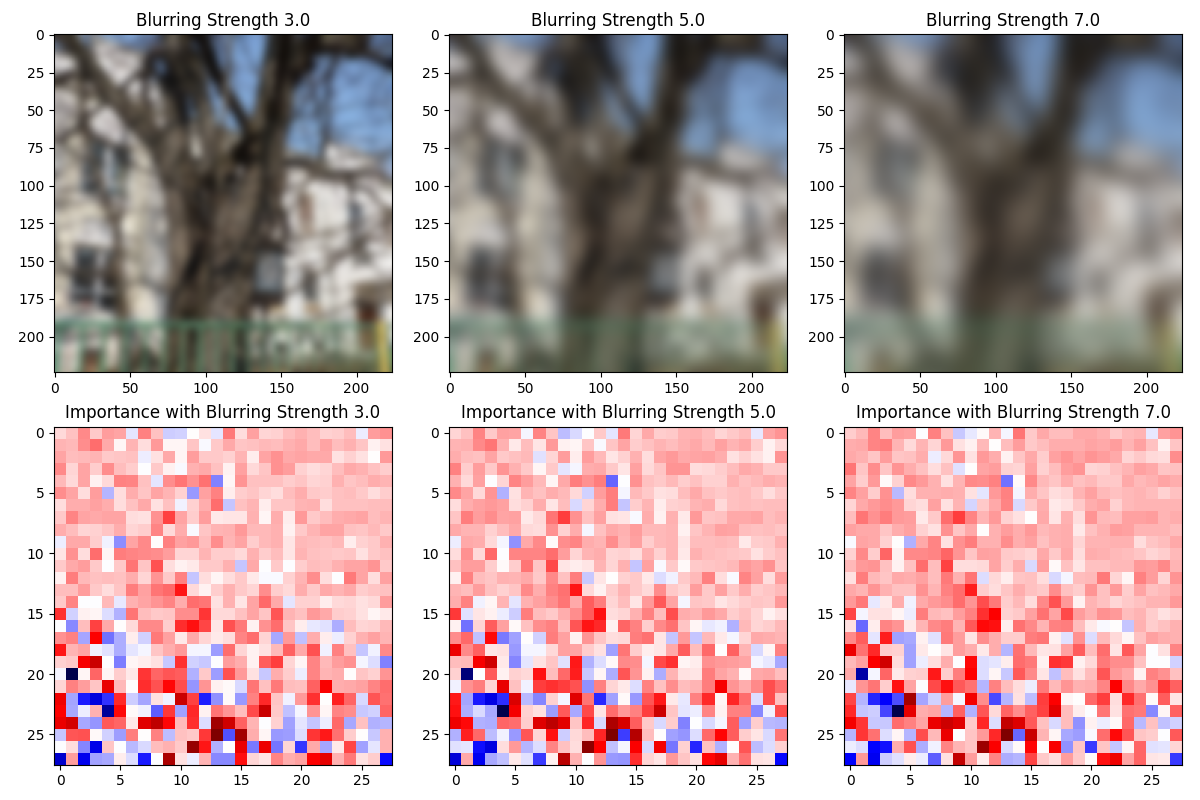

In [22]:
blurring_strengths = [3.0, 5.0, 7.0]
superpixel_size = 8
blurred_images = []

# Generate and visualize blurred image
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

i = 0
for sigma in blurring_strengths:
  # apply Gaussian blur, creating a new image
  blurred = ski.filters.gaussian(
      display_images[0], sigma=(sigma, sigma), truncate=3.5, channel_axis=-1)
  blurred_images.append(blurred)

  # display the blurred image
  axes[0, i].imshow(blurred)
  axes[0, i].set_title(f'Blurring Strength {sigma}')

  # Generate importance map
  blurred_baseline = model_transforms(blurred).to(device)
  single_importance = occlusion(torch.stack([model_transforms(display_images[0])]).to(device), model, pred_class_idx[0], baseline=blurred_baseline, superpixel_size=superpixel_size)
  single_importance = single_importance.squeeze().cpu()

  m = single_importance.abs().max()
  min = single_importance.min()
  axes[1, i].imshow(single_importance, vmin=min, vmax=m, cmap='seismic') # specify min/max value plt.show()
  axes[1, i].set_title(f'Importance with Blurring Strength {sigma}')

  i += 1

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
# plt.show()
plt.savefig(f"q2_e.png")

## Gradient Based Explanations

Several explanation methods are based on gradients with respect to the input image. These are often faster than removal-based approaches, and they are widely used to explain deep models. In this problem, we’ll implement several gradient-based methods from scratch.

In [9]:
import matplotlib.pyplot as plt

(a) Vanilla Gradients

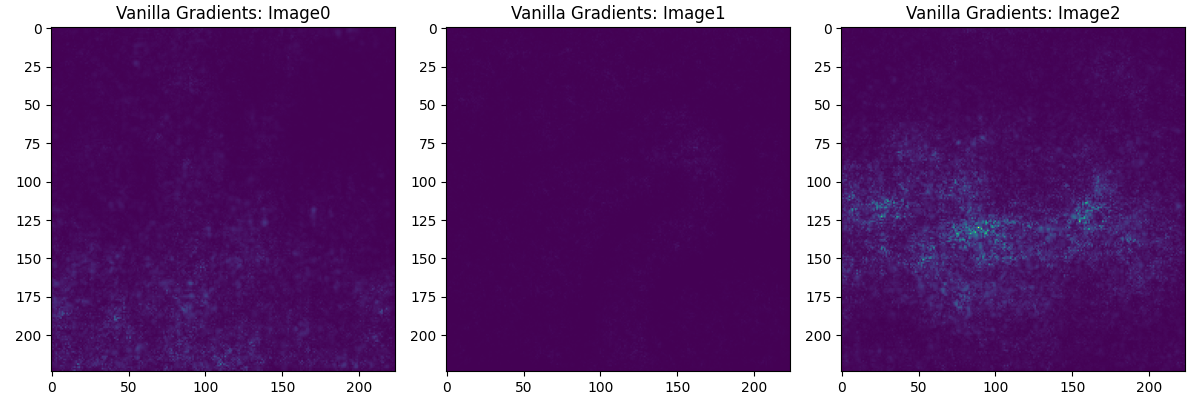

In [31]:
def calculate_gradients(imgs, model, target_labels):
    ''' Args:
    imgs: torch.Tensor of pre-processed images, size = (batch, 3, 224, 224) model: PyTorch classifier
    target_labels: torch.Tensor of classes for each image, size = (batch,)
    Returns:
    gradients: gradients for the target class, shape = (batch, 3, 224, 224)
    '''
    # Prepare for model.
    imgs = imgs.clone()
    imgs.requires_grad = True
    # Make prediction.

    # output = model(imgs).softmax(dim=1)
    # output_y = output.gather(1, target_labels.view(-1, 1))
    output = model(imgs).softmax(dim=1)
    # Sum outputs for target classes.
    mask = torch.zeros(output.shape).to(device)
    for i, target in enumerate(target_labels):
        mask[i, target] = 1
    backprop_output = torch.sum(output * mask)

    # Calculate gradients.
    model.zero_grad()
    backprop_output.backward()
    # Calculate the gradients of the output with respect to the input images
    # gradients = torch.autograd.grad(outputs=output_y, inputs=imgs, grad_outputs=torch.ones_like(output),
    #                                 create_graph=True, retain_graph=True)[0]

    # Convert gradients to numpy.
    gradients = imgs.grad.detach()

    return gradients


def vanilla_gradients(imgs, model, target_labels):
    '''
    Args:
    imgs: torch.Tensor of pre-processed images, size = (batch, 3, 224, 224)
    model: PyTorch classifier
    target_labels: torch.Tensor of classes for each image, size = (batch,)
    Returns:
    saliency: tensor of saliency values, shape = (batch, 224, 224)
    '''
    gradients = calculate_gradients(imgs, model, target_labels)

    # Calculate the saliency map by taking the absolute value of the gradients
    saliency = torch.abs(gradients)

    saliency = torch.sum(saliency, dim=1)

    return saliency

images = torch.stack([model_transforms(img) for img in display_images[:3]]).to(device)
vanilla = vanilla_gradients(images, model, pred_class_idx)

# Generate plot
# plt.figure()
# plt.imshow(vanilla, vmin=0, vmax=vanilla.max()) # specify min/max value plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
  axes[i].imshow(vanilla[i].squeeze().cpu(), vmin=vanilla.min(), vmax=vanilla.max())
  axes[i].set_title(f'Vanilla Gradients: Image{i}')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
# plt.show()
plt.savefig(f"q3_a.png")

(b) SmoothGrad

Implement SmoothGrad, which adds Gaussian noise to the input and averages the gradients.

In your function, you can take the absolute value either before or after averaging (whichever looks better), and sum across channels before returning the result. Plot the output for the first three images in the dataset.

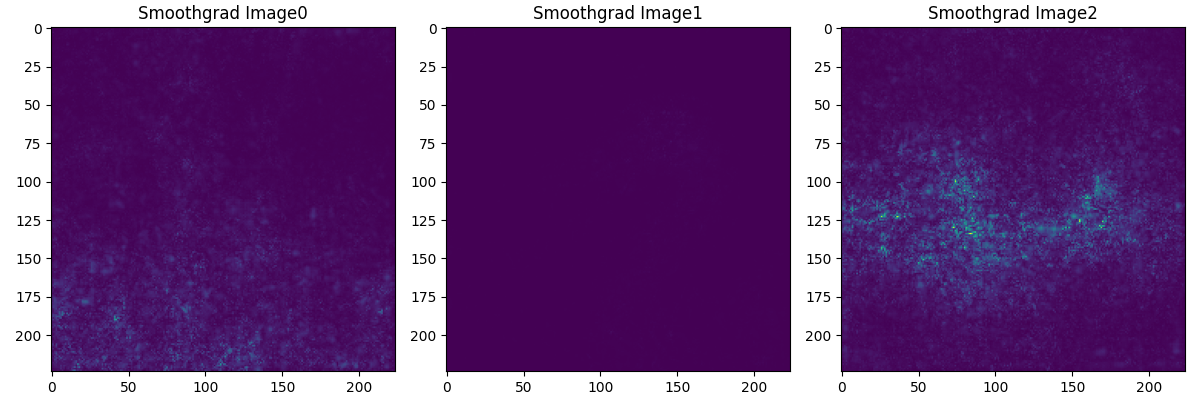

In [32]:
def smoothgrad(imgs, model, target_labels, samples=50, sigma=0.1):
    '''
    Args:
    imgs: torch.Tensor of pre-processed images, size = (batch, 3, 224, 224)
    model: PyTorch classifier
    target_labels: torch.Tensor of classes for each image, size = (batch,)
    samples: number of random noise samples
    sigma: scale for random noise
    Returns:
    saliency: tensor of saliency values, shape = (batch, 224, 224)
    '''
    saliency = torch.zeros_like(imgs)

    for i in range(samples):
        noise = torch.randn_like(imgs) * sigma
        noisy_imgs = imgs + noise

        # noisy_imgs.requires_grad = True
        # outputs = model(noisy_imgs)

        # Calculate gradients
        # model.zero_grad()
        # outputs.backward(torch.ones_like(outputs))

        grads = calculate_gradients(noisy_imgs, model, target_labels) # [batchsize, 3, 224, 224]

        saliency += grads
        # saliency += torch.abs(grads)

    saliency /= samples
    saliency = torch.abs(saliency)

    saliency = torch.sum(saliency, dim=1)
    return saliency

images = torch.stack([model_transforms(img) for img in display_images[:3]]).to(device)
smoothgrads = smoothgrad(images, model, pred_class_idx)

# Generate plot
# plt.figure()
# plt.imshow(vanilla, vmin=0, vmax=vanilla.max()) # specify min/max value plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
  axes[i].imshow(smoothgrads[i].squeeze().cpu(), vmin=smoothgrads.min(), vmax=smoothgrads.max())
  axes[i].set_title(f'Smoothgrad Image{i}')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
# plt.show()
plt.savefig(f"q3_b.png")

(c) Implement **Integrated Gradients**, which averages the gradient along a path and multiplies it by the input minus the baseline.

In your function, for simplicity, take the absolute value and sum across the channels. Plot the results for the first three images in the dataset, using the same baseline provided for Problem 2(c).

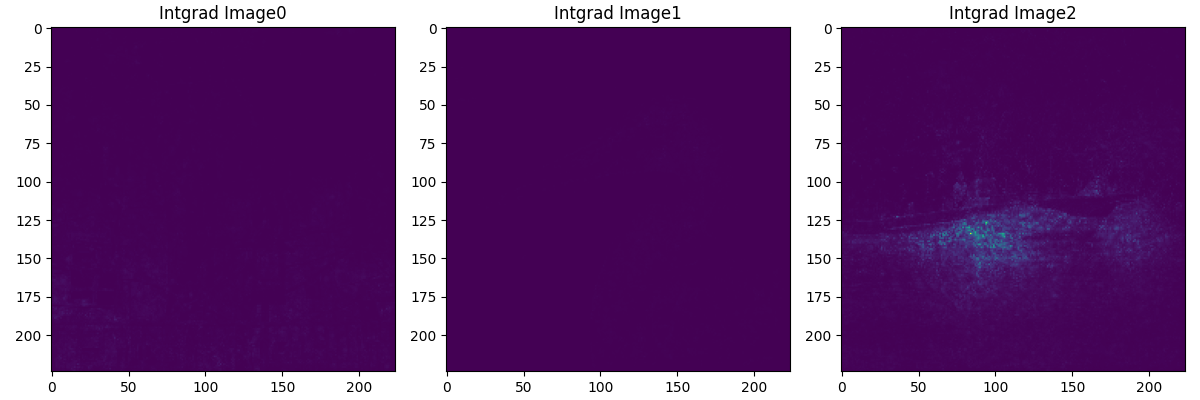

In [35]:
# Generate black image, then apply pre-processing
baseline = model_transforms(np.zeros((224, 224, 3), np.uint8)).to(device)

def integrated_gradients(imgs, model, target_labels, baseline, steps=50):
  ''' Args:
  imgs: torch.Tensor of pre-processed images, size = (batch, 3, 224, 224) model: PyTorch classifier
  target_labels: torch.Tensor of classes for each image, size = (batch,)
  baseline: baseline value for held-out features
  steps: number of steps along path to baseline
  Returns:
  saliency: tensor of saliency values, shape = (batch, 224, 224) '''

  integrated_gradients = torch.zeros_like(imgs)

  for i in range(steps):
    input = baseline + (i / steps) * (imgs - baseline)
    gradients = calculate_gradients(input, model, target_labels)

    # Approximate the integral using the trapezoidal rule.
    # integrated_gradients += (input - baseline) * torch.stack(gradients).mean(0) / steps
    integrated_gradients += (imgs - baseline) * torch.abs(gradients) / steps ###TODO????

  # sum across the channels
  saliency = torch.sum(integrated_gradients, dim=1)

  return saliency

images = torch.stack([model_transforms(img) for img in display_images[:3]]).to(device)
intgrads = integrated_gradients(images, model, pred_class_idx, baseline)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
  axes[i].imshow(intgrads[i].squeeze().cpu(), vmin=intgrads.min(), vmax=intgrads.max())
  axes[i].set_title(f'Intgrad Image{i}')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
# plt.show()
plt.savefig(f"q3_c.png")

(d)

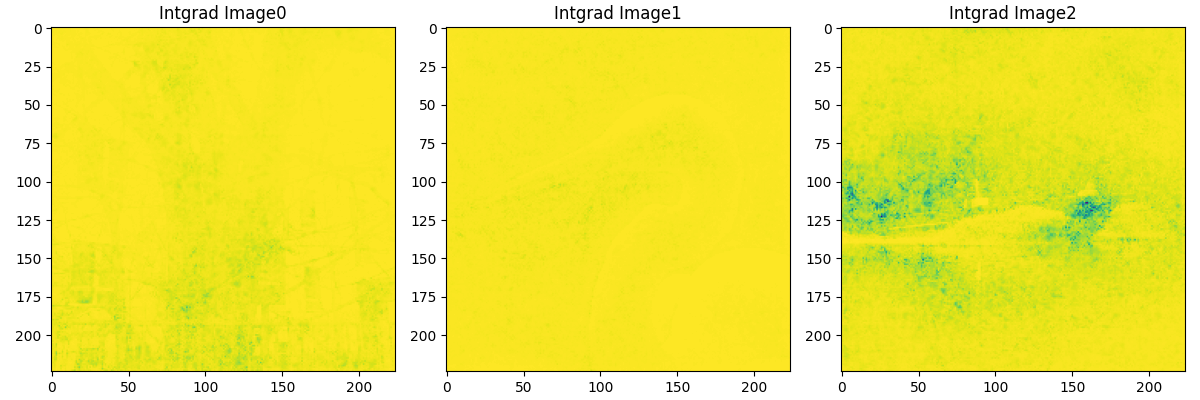

In [38]:
# Generate white image, then apply pre-processing
baseline = model_transforms(255 * np.ones((224, 224, 3), np.uint8)).to(device)

# IntGrad
images = torch.stack([model_transforms(img) for img in display_images[:3]]).to(device)
intgrads = integrated_gradients(images, model, pred_class_idx, baseline)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
  axes[i].imshow(intgrads[i].squeeze().cpu(), vmin=intgrads.min(), vmax=intgrads.max())
  axes[i].set_title(f'Intgrad Image{i}')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
# plt.show()
plt.savefig(f"q3_d.png")


## Ablation Metrics

(a) First, prepare the explanations that we’ll evaluate using the metrics. Use the first ten images from the dataset and generate feature importance values using Occlusion (with 8 × 8 superpixels) and SmoothGrad (using 50 samples and a noise level of your choice). In addition, include a Random baseline: generate a saliency map for each image that is Gaussian noise. Plot the saliency maps side-by- side for one of the images.

In [ ]:
# Use the first ten images from the dataset and 
test_images = torch.stack([model_transforms(img) for img in display_images[:10]]).to(device)
test_pred = model(test_images).softmax(dim=1)
test_pred_class_idx = torch.argmax(test_pred, dim=1)

# Generate feature importance values using Occlusion (with 8 × 8 superpixels) and SmoothGrad (using 50 samples and a noise level of your choice).
# random_baseline = model_transforms(255 * np.random.rand(224, 224, 3)).to(device) #????

random_baseline = np.random.rand(224, 224, 3)

occlusion_baseline = model_transforms(np.zeros((224, 224, 3), np.uint8))
Importance_Occlusion = occlusion(test_images, model, test_pred_class_idx, occlusion_baseline, superpixel_size=8)

Importance_SmoothGrad = smoothgrad(test_images, model, test_pred_class_idx, samples=50, sigma=0.1)

In [ ]:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot Importance_Occlusion
axes[0].imshow(Importance_Occlusion.squeeze().cpu()[5], cmap='hot')
axes[0].set_title('Importance Map: Occlusion')

# Plot Importance_SmoothGrad
axes[1].imshow(Importance_SmoothGrad.squeeze().cpu()[5], cmap='hot')
axes[1].set_title('Importance Map: SmoothGrad')

# Plot random_baseline
axes[2].imshow(random_baseline, cmap='hot')
axes[2].set_title('Random Baseline')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()


(b) To reduce the number of predictions required for the metrics, we’ll ensure that all explanations correspond to 8 × 8 superpixels. The Occlusion (8 × 8) explanation does this already, but SmoothGrad and Random do not. Reduce their granularity by summing the importance within each non-overlapping 8 × 8 superpixel. Plot the new saliency maps for the same image. Hint: consider using PyTorch’s AvgPool2d operation.

In [ ]:
import torch.nn as nn

Importance_SmoothGrad_avg = nn.AvgPool2d(8)(Importance_SmoothGrad)
Importance_Random_avg = nn.AvgPool2d(8)(random_baseline.view([3,224,224]).unsqueeze(0))

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot Importance_Occlusion
axes[0].imshow(Importance_Occlusion.squeeze().cpu()[5], cmap='hot')
axes[0].set_title('Importance Map: Occlusion')

# Plot Importance_SmoothGrad
axes[1].imshow(Importance_SmoothGrad_avg.squeeze().cpu()[5], cmap='hot')
axes[1].set_title('Importance Map: SmoothGrad')

# Plot random_baseline
axes[2].imshow(Importance_Random_avg.squeeze(), cmap='hot')
axes[2].set_title('Random Baseline')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

(c) Write a function to generate an array of prediction probabilities as features are inserted in order of most to least important (**Insertion**). Rather than inserting individual pixels, insert 8 * 8 superpixels. 

As a baseline value, use the zeros baseline from Problem 2(c). Plot the curve for a single image and just the **Occlusion** explanation, and calculate the area under the curve using the trapezoidal rule.


In [ ]:
baseline = model_transforms(np.zeros((224//8, 224//8, 3), np.uint8))

def insertion(img, model, importance, target_label, baseline):
    '''
    Args:
      img: image to ablate, size = (1, 3, 244, 244)
      model: PyTorch classifier
      importance: feature importance values, size = (1, 28, 28)
      target_label: index of target class
      baseline: baseline value for held-out features
      
    Returns:
      curve: array of prediction probabilities after each step
      num_feats: array of number of features after each step
    '''
    curve = []
    num_feats = []
    
    # Initialize the ablated image
    ablated_img = baseline.clone()
    
    # Flatten the importance map
    importance_flat = importance.view(-1)
    
    # Sort the importance values in descending order
    sorted_indices = torch.argsort(importance_flat, descending=True)
    
    # Iterate over the sorted indices
    for idx in sorted_indices:
      # Insert the corresponding feature
      ablated_img[0, idx * 28 : idx * 28 + 28, idx * 28 : idx * 28 + 28] = img[0, idx * 28 : idx * 28 + 28, idx * 28 : idx * 28 + 28]
      
      # Make a prediction using the ablated image
      prediction = model(ablated_img).softmax(dim=1)
      
      # Get the probability of the target class
      target_prob = prediction[0, target_label].item()
      
      # Append the probability to the curve
      curve.append(target_prob)
      
      # Append the number of remaining features to num_feats
      num_feats.append(len(curve))
    
    return curve, num_feats
    

In [ ]:
def calculate_auc(curve, num_feats):
    auc = 0.0

    for i in range(1, len(curve)):
        width = num_feats[i] - num_feats[i-1]
        avg_height = (curve[i] + curve[i-1]) / 2.0
        area = width * avg_height
        auc += area

    return auc


In [ ]:
insertion(test_images[5], model, Importance_Occlusion[5], test_pred_class_idx[5], baseline)